In [173]:
import numpy as np
import rasterio
import rasterio.features
from rasterio.transform import Affine
from shapely import geometry
import matplotlib.pyplot as plt
# import sys
# sys.path.append("/home/CGaydon/Documents/LIDAR PAC/plot_vegetation_coverage/")

In [174]:
def imshow_band(band_arr):
    plt.figure(figsize=(8,8))
    plt.imshow(band_arr, cmap='pink')
    plt.colorbar()
    plt.show()

def visualize_band(src, band_idx):
    imshow_band(src.read(band_idx))

(7, 402, 244)


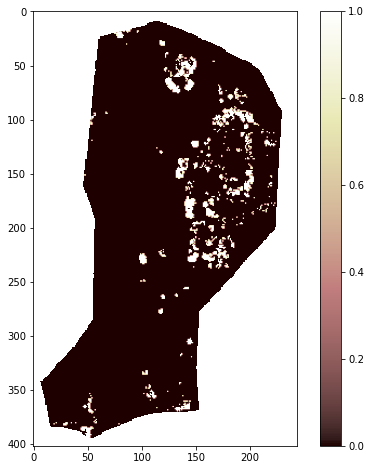

In [195]:
tif_path = "/home/CGaydon/Documents/LIDAR PAC/plot_vegetation_coverage/experiments/inference/PROD/2021-06-28_16h47m07s/img/rasters/004006880-1-2/prediction_raster_parcel_004006880-1-2.tif"
src = rasterio.open(tif_path)
src_mosaic = src.read()  # (Vb, Vm_soft, Vh, Vm_hard)
print(src_mosaic.shape)
visualize_band(src, 4)

In [196]:
### Full process :
# Eliminate zones < 5 pixels
# Vectorize
# Add buffer 2m buffer of hard vegetation to the outside of the parcel
# Negative buffer of 1.5m
# Delete outside buffer :
# get back to raster


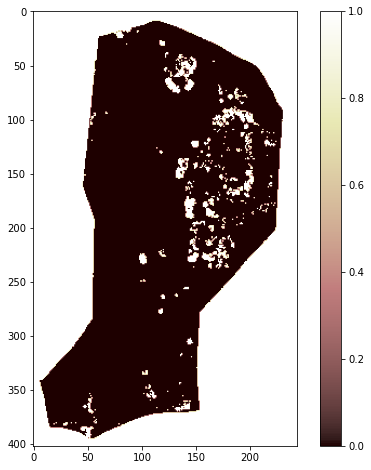

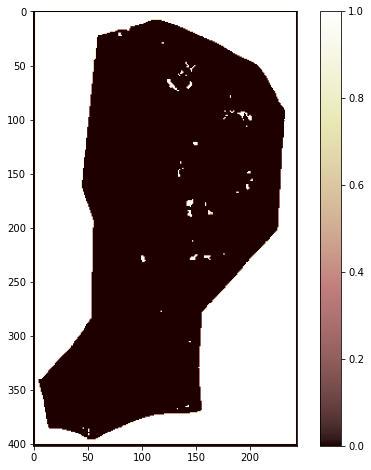

0.9091513


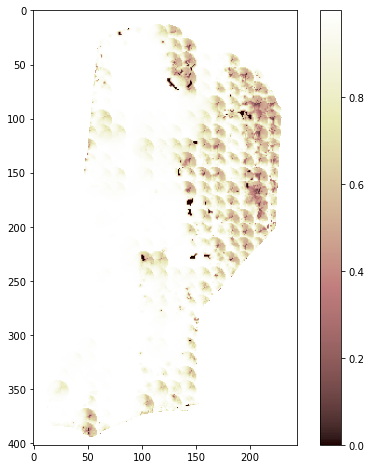

0.90522003


In [197]:
# https://gis.stackexchange.com/a/131080/184486 ?
mosaic = src_mosaic.copy()

veg_moy_hard = mosaic[3]
mask = np.isnan(veg_moy_hard)

# Eliminate zones < 5 pixels.
# Note: Min is to keep small patches of zeros surround by ones. We keep nans after int conversion

veg_moy_hard_sieve = rasterio.features.sieve(
    veg_moy_hard.astype(np.int16), 5, mask=mask
)
veg_moy_hard_sieve[mask] = 1  # set hard veg outside of parcel to avoid border effects.
veg_moy_hard = np.nanmin([[veg_moy_hard], [veg_moy_hard_sieve]], axis=0).squeeze()
imshow_band(veg_moy_hard)

# Vectorize + negative buffer of 1.5m -> enlarge shape with value = 1 by 1.5m

BUFFER_WIDTH_METERS = -1.5
poly = [
    geometry.shape(polygon).buffer(BUFFER_WIDTH_METERS)
    for polygon, value in rasterio.features.shapes(veg_moy_hard, mask=None)
    if value == 1
]
poly = [s for s in poly if not s.is_empty]

# Create an inaccessibility array mask (where True for pixels in shape)
# Source: https://rasterio.readthedocs.io/en/latest/api/rasterio.features.html#rasterio.features.geometry_mask
identity_transform = Affine(1.0, 0.0, 0.0, 0.0, 1.0, 0.0)
inaccessibility_mask = rasterio.features.geometry_mask(poly, veg_moy_hard.shape, identity_transform, all_touched=False, invert=True)
imshow_band(inaccessibility_mask)

# Gather results

veg_b = mosaic[0]
veg_moy_soft = mosaic[1]
max_veg_b_or_moy = np.max([[veg_b],[veg_moy_soft]],axis=0).squeeze()
print(np.nanmean(max_veg_b_or_moy))
max_veg_b_or_moy[inaccessibility_mask] = 0
max_veg_b_or_moy[mask] = np.nan
imshow_band(max_veg_b_or_moy)
print(np.nanmean(max_veg_b_or_moy))